## necessary imports

In [29]:
import json 
import glob
import tensorflow as tf 
from tensorflow import keras 
from keras.models import model_from_json
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt

## load the dataset infos



In [23]:
data , data_infos = tfds.load('oxford_flowers102', split='train[:1%]', with_info=True, as_supervised=True)


## Download necessary files(the model's config and the model's weights)

In [6]:
!gdown --id 1OXkQ2hieGJl_8o0V5Dbd8XMVufowcu8w -O flowerz-predeploy-nb.zip
!unzip flowerz-predeploy-nb.zip

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OXkQ2hieGJl_8o0V5Dbd8XMVufowcu8w
To: /content/flowerz-predeploy-nb.zip
100% 13.7M/13.7M [00:00<00:00, 124MB/s]
Archive:  flowerz-predeploy-nb.zip
   creating: flowerz-predeploy-nb/
   creating: flowerz-predeploy-nb/oxford_102_inference_images/
  inflating: flowerz-predeploy-nb/oxford_102_inference_images/lotus_1.jpeg  
  inflating: flowerz-predeploy-nb/oxford_102_inference_images/passion_1.jpeg  
  inflating: flowerz-predeploy-nb/oxford_102_inference_images/petunia_1.jpeg  
  inflating: flowerz-predeploy-nb/oxford_102_inference_images/tulip_1.jpeg  
  inflating: flowerz-predeploy-nb/model_config.json  
  inflating: flowerz-predeploy-nb/model_weights.h5  


## Build the model

In [11]:
config_path = "/content/flowerz-predeploy-nb/model_config.json"
weights_path = "/content/flowerz-predeploy-nb/model_weights.h5"
custom_objects={'KerasLayer': hub.KerasLayer}

In [13]:
with open(config_path, "r") as file :
  json_config = file.read()

with keras.utils.custom_object_scope(custom_objects):
  model = model_from_json(json_config)

In [14]:
model.load_weights(filepath=weights_path)
model.summary()

Model: "mobilenet_v2_keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 head_classifier (Sequential  (None, 102)              1416294   
 )                                                               
                                                                 
Total params: 3,674,278
Trainable params: 1,416,294
Non-trainable params: 2,257,984
_________________________________________________________________


## Test Inference

In [26]:
## inference
def process_image(img, img_res=224):
  image = np.squeeze(img)     
  image = tf.image.resize(image , (img_res,img_res))/255.0
  return image

In [24]:
get_label_name = data_infos.features['label'].int2str 


In [27]:
def predict(model , img_path, top_k=3):
  img = Image.open(img_path) 
  img = np.asarray(img)
  processed_img = process_image(img)
  
  prediction = model.predict(np.expand_dims(processed_img, axis=0))  
  top_values , top_indices = tf.math.top_k(prediction, top_k)

  print("Probability Scores :", top_values.numpy()[0])
  top_classes = [get_label_name(value) for value in top_indices.numpy()[0]]

  print("Corresponding Classes :", top_classes)
  return top_values.numpy()[0], top_classes

1/1 [==============================] - 1s 916ms/step
Probability Scores : [0.27227136 0.1741967  0.08609764]
Corresponding Classes : ['petunia', 'artichoke', 'globe thistle']


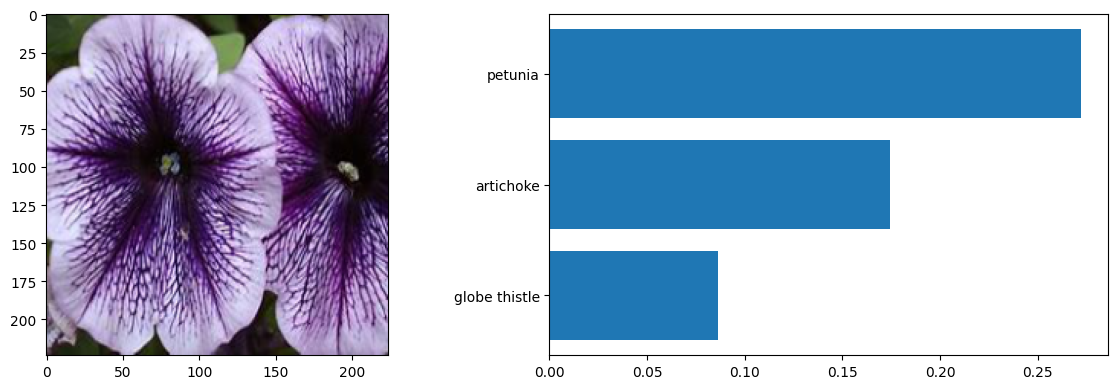

1/1 [==============================] - 0s 67ms/step
Probability Scores : [0.9710689  0.00999472 0.0058581 ]
Corresponding Classes : ['lotus', 'magnolia', 'siam tulip']


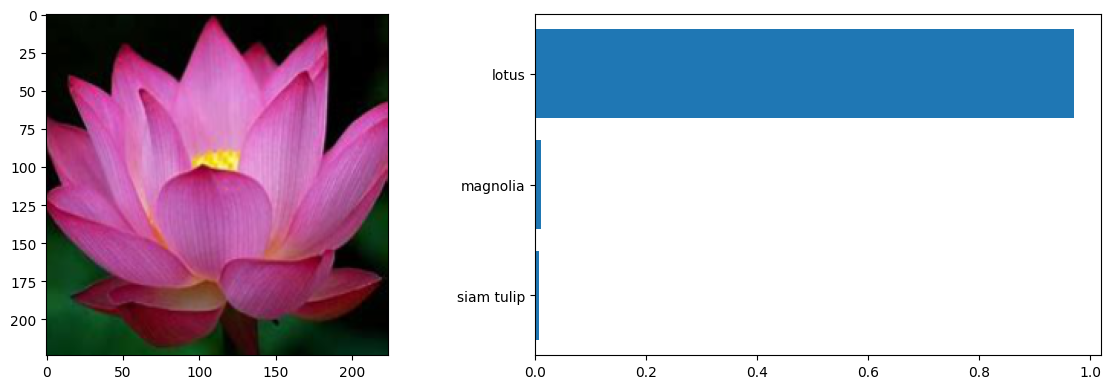

1/1 [==============================] - 0s 63ms/step
Probability Scores : [0.7750527  0.1020041  0.02110576]
Corresponding Classes : ['mallow', 'rose', 'anthurium']


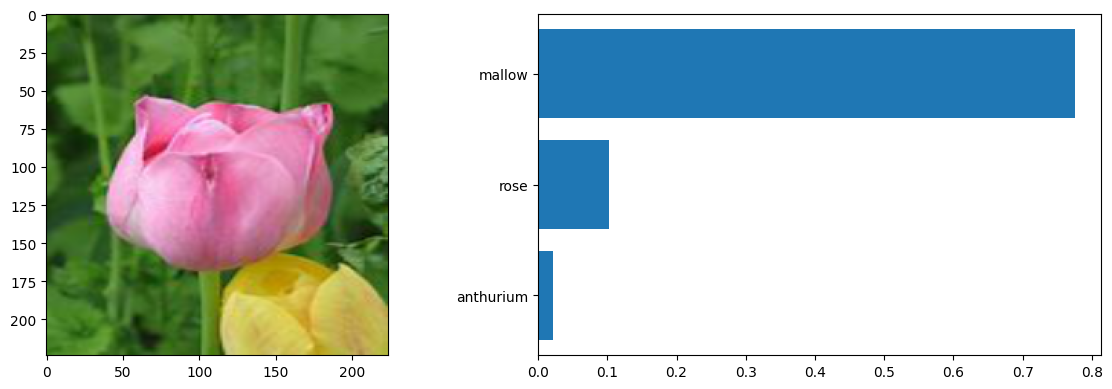

1/1 [==============================] - 0s 55ms/step
Probability Scores : [9.9708194e-01 1.9318828e-03 3.3872327e-04]
Corresponding Classes : ['passion flower', 'pincushion flower', 'bee balm']


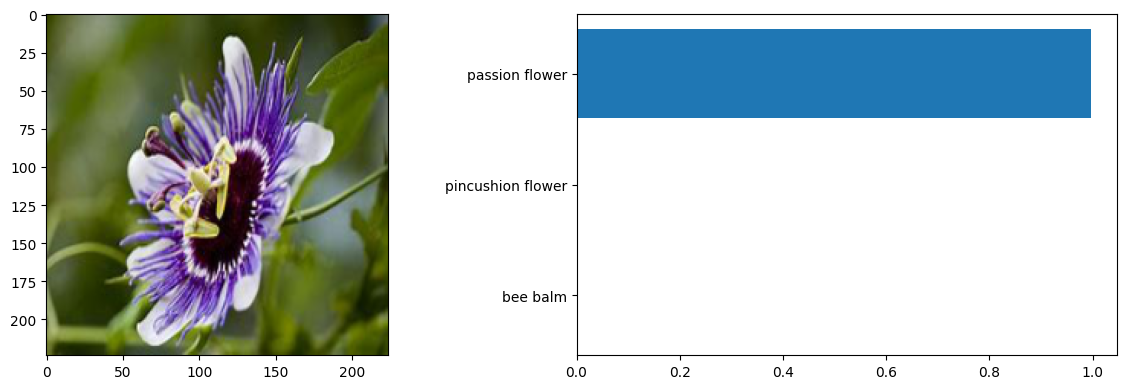

In [30]:
images_path = "/content/flowerz-predeploy-nb/oxford_102_inference_images"
files = glob.glob('{}/*.jpeg'.format(images_path))

for image_path in files :
  img = Image.open(image_path)                
  img = np.asarray(img)
  processed_img = process_image(img)
  probs , classes = predict(model , image_path)
  fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
  ax1.imshow(processed_img)
  ax2 = plt.barh(classes[::-1], probs[::-1])
  plt.tight_layout()
  plt.show()